## Sait Elmas 2022 Summer Practice
### Probabilistic Matrix SVD
On this work I will study the article "Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions" by N. Halko, P. G. Martinson, J. A. Tropp. Applications of algorithms described in the article have been developed by Julia Programming Language 


In [21]:
using Random
using Statistics
using Plots
using LinearAlgebra
using Printf
using SparseArrays
using MatrixMarket
using DelimitedFiles
using PlotlyJS
include("lra.jl")
rng = MersenneTwister();


### Algorithm 4.1 Randomized Range Finder
Input: $m \times n$ matrix $A$, integer $l$.

Outpu: $ m \times l$ matrix $Q$, whose range approximates $A$.

1. Draw an $n \times l$ Gaussian random matrix $\Omega$
2. Form the $m \times l$ matrix $Y=A \Omega $
3. Construct an $m \times l$ matrix $Q$ whose columns form an orthonormal basis for the range of $Y$.


Below there are two different tests. Algorithm is given increasing l values up to range of A and the difference with the actual matrix and the approximation is plotted in spectral norm.
1. A random real sparse matrix with dimension 1000x500. 
2. pde2961.mtx from matrix market with following properties.
    - 2961 x 2961 with 14585 entries.
    - Rank 2961
    - Frobenius norm: $2.2\cdot 10^2$
    - Spectral norm: $10$
    - Full specification and the matrix in .mtx format is [here](https://math.nist.gov/MatrixMarket/data/NEP/matpde/pde2961.html).
    
3. eris1176.mtx from matrix market with following properties
    - 1176x1176 with 9864 entries
    - Rank 774
    - Frobenius norm: $136.2$
    - Spectral norm: $80.07$
    - Full specification and the matrix in .mtx format is [here](https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/smtape/eris1176.html).

4. lns__511.mtx from matrix market with following properties
    - 511x511 with 2796 entries
    - Rank 391.
    - Frobenius norm: $1.1 \times 10^{11}$
    - Spectral norm : $\times 10^{10}$
    - ull specification and the matrix in .mtx format is [here](https://math.nist.gov/MatrixMarket/data/Harwell-Boeing/lns/lns__511.html)


As expected the matrix $(I-Q*Q') = 0$ if $l = rank(A)$ since $Q$ would be a square orthonormal matrix.

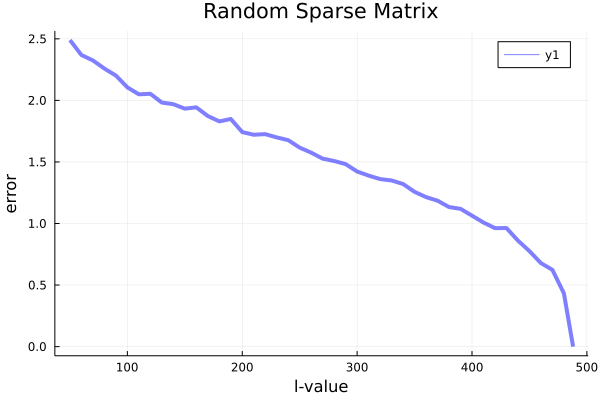

In [3]:
A = sprand(1000,500,0.004) # generates a random real sparse matrix (1000x500) and the dencity = 0.004
mmwrite("data/random_sparse.mtx", A)
ra = rank(A)
xs = collect(50:10:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="Random Sparse Matrix")

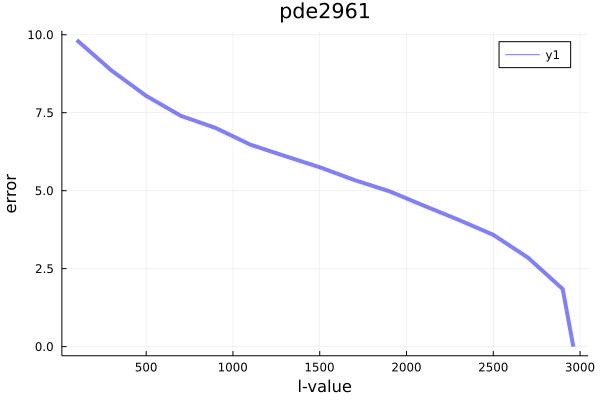

In [2]:
A = mmread("data/pde2961.mtx")
ra = 2961
xs = collect(100:200:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="pde2961")

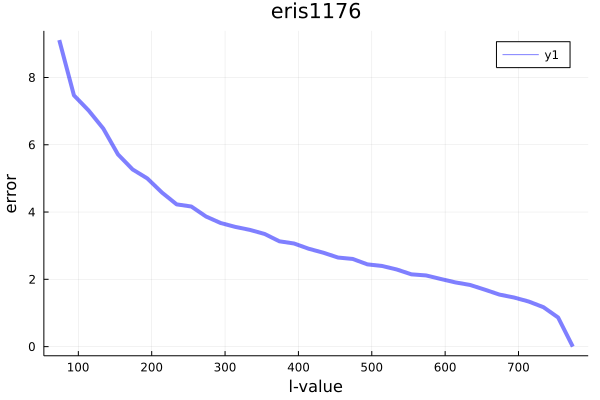

In [4]:
A = mmread("data/eris1176.mtx")
ra = 774
xs = collect(74:20:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="eris1176")

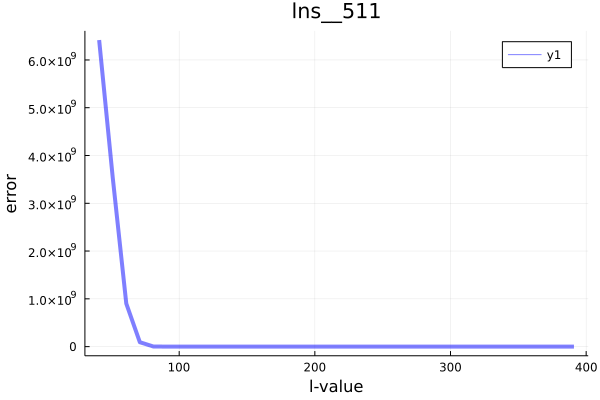

In [5]:
A = mmread("data/lns__511.mtx")
ra = 391
xs = collect(41:10:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="lns__511")

### Algorithm 4.2 Adaptive Randomized Range Finder
Input: mxn matrix $A$, a floating point number $\epsilon$ as tolerance, an integer $r$ as oversampling parameter.

Output: mxl matrix Q, whose range approximates A.

1. Draw standard Gaussian vectors $w^{(1)}, ... , w^{(n)}$ of length $n$.
2. For $i=1,2,...,r$ compute $y^{(i)} = Aw^{(i)}$
3. j=0
4. $Q^{(0)} = []$, the $mx0$ empty matrix.
5. while $max\{\left \Vert y^{(j+1)} \right \Vert, \left \Vert y^{(j+2)} \right \Vert, ... , \left \Vert y^{(j+r)} \right \Vert \} \gt \epsilon / (10 \sqrt{2 / \pi})$
6. &emsp; j=j+1
7. &emsp; Overwrite $y^{(j)}$ by $(I-Q^{(j-1)}Q^{(j-1)*})y^{(j)}$ 
8. &emsp; $q^{(j)} = y^{(j)} / \Vert y^{(j)} \Vert$
9. &ensp; $Q^{(j)} = [Q^{(j-1)}q^{(j)}]$
10. &ensp; Draw a standard Gaussian Vector $w^{(j+r)}$ of length $n$.
11. &ensp; $y^{(j+r)} = (I-Q^{(j)} Q^{(j)*})A^{(j+r)}$
12. &ensp; for $i = (j+1),(j+2),...,(j+r-1)$
13. &ensp; &ensp; Overwrite $y^{(i)}$ by $y^{(i)} - q^{(j)} \langle q^{(j)}, y^{(j)} \rangle $
14. &ensp; end for
15. end while
16. $Q = Q^{(j)}$

Since the rank is not known in priori (in contrast my testing routine for the first algorithm) it is not so easy to control the error just by putting a random $l$ value to algorithm. On this variation the algorithm (4.2) takes an error value and try to produce an approximation regarding the given error value.

The idea here; algorithm is calculating Q incrementally and at each step checks the error for very cheap cost.

---
Below the output of this application for selected 4 matrices described previously can be seen

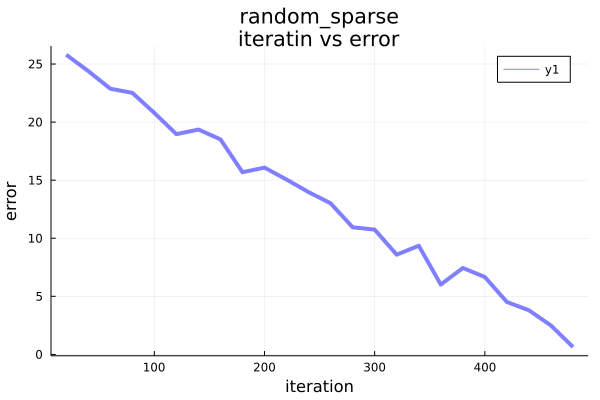

In [6]:
A = mmread("data/random_sparse.mtx")
Q,iterations, errors = arrf(A,0.1, 10, 20);
mmwrite("data/4.2_random_sparse_output.mtx",sparse(Q))
plot(iterations, errors, xaxis=("iteration"), yaxis="error", line = (0.5, 4, :blue), title="random_sparse\niteratin vs error")



In [ ]:
A = mmread("data/pde2961.mtx")
Q,iterations,errors= arrf(A,0.1, 10, 100);
mmwrite("data/4.2_pde2961_output.mtx",sparse(Q))
plot(iterations, errors, xaxis=("iteration"), yaxis="error", line = (0.5, 4, :blue), title="pde2961\niteratin vs error")



In the above run the matrix pde2961 has been used. It has the Frobenius norm approximately 220 and the error is around 220 in the beginning of the iteration. It took about 27 minutes to approximate the matrix with an error 0.1 and an intel i3 3200mhz 4-core CPU. Since the error is so small compared with the norm of the matrix, the algorithm has reveal the full rank in 27 minutes. However in practice error tolerance should not be that strict and algorithm can be used more effectively with a more powerful hardware.

Below the graph containing error vs iteration values can be seen.

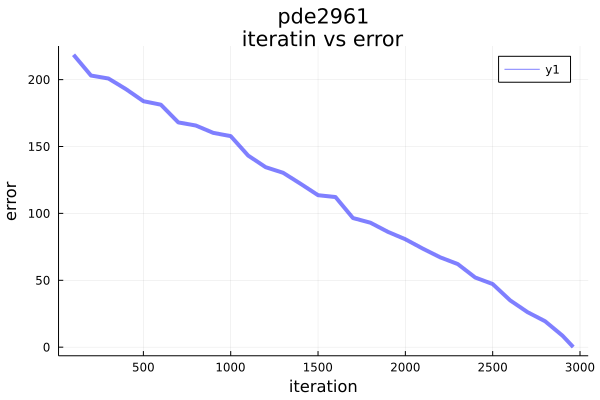

In [7]:
errors = readdlm("data/errors_4.2.1.txt", '\t', Float64, '\n')
iterations = readdlm("data/iterations_4.2.1.txt", '\t', Int, '\n')
plot(iterations, errors, xaxis=("iteration"), yaxis="error", line = (0.5, 4, :blue), title="pde2961\niteratin vs error")


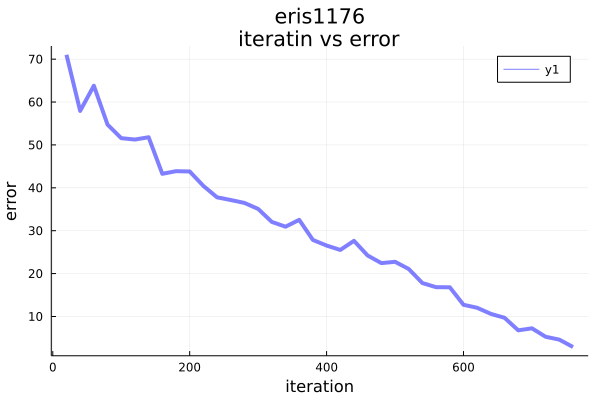

In [8]:
A = mmread("data/eris1176.mtx");
Q,iterations, errors = arrf(A,0.1,10,20);
mmwrite("data/4.2_eris1176_output.mtx", sparse(Q))
plot(iterations, errors, xaxis=("iteration"), yaxis="error", line = (0.5, 4, :blue), title="eris1176\niteratin vs error")


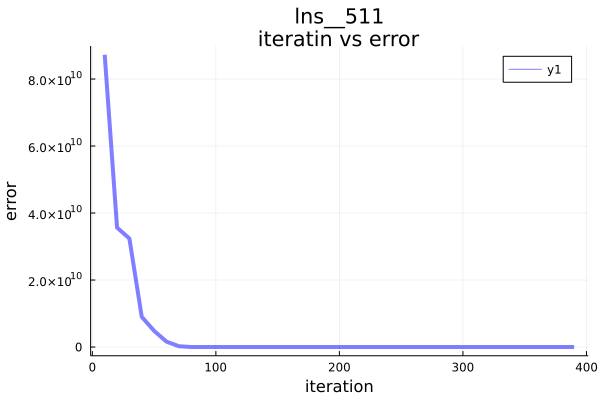

In [9]:
A = mmread("data/lns__511.mtx");
Q,iterations, errors = arrf(A,1,10,10);
mmwrite("data/4.2_lns__511_output.mtx", sparse(Q))
plot(iterations, errors, xaxis=("iteration"), yaxis="error", line = (0.5, 4, :blue), title="lns__511\niteratin vs error")


### Algorithm 4.3 Randomized Power Iteration 
Input $m\times n$ matrix A, integers $l$ and $q$.

Output $m \times l$ matrix Q, whose range approximates range of A.

1. Draw an $n \times l$ Gaussian random matrix $\Omega$
2. Form the $m \times l$ matrix $Y = (AA^*)^qA\Omega $
3. Construct an $m \times l$ matri $Q$ whose columns form an orthonormal basis for the range of $Y$, e.g., via $QR$ factorization $Y=QR$


On this algorithm randomized sampling is applied to the matrix $B = (AA^*)^qA$ instead of $A$. B has same left and right singular vectors ($U$ and $V$) with $A$ but singular values are scaled up and down ($\sigma_j(B) = \sigma_j(A)^{2q+1}$). Hence we expect a quicker range finder algorithm by this change.

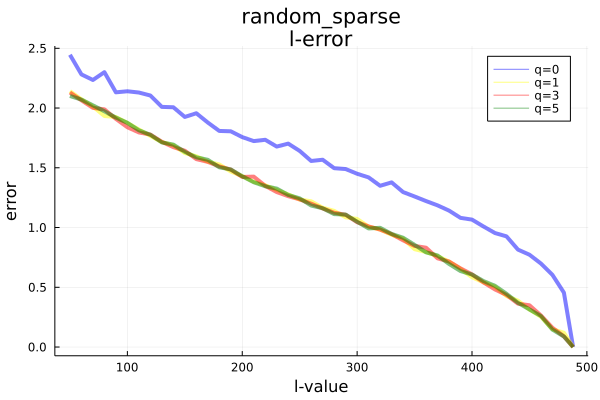

In [10]:
A = mmread("data/random_sparse.mtx")
ra = rank(A)
xs = collect(50:10:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er0 = []
er1 = []
er3 = []
er5 = []
for i in xs 
    Q0 = rpi(A,i,0)
    append!(er0,opnorm((1.0I - Q0*Q0')*A))
end
plot(xs, er0, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="random_sparse\nl-error", label="q=0")

for i in xs 
        Q1 = rpi(A,i,1)
        append!(er1,opnorm((1.0I - Q1*Q1')*A))
end
plot!(xs, er1, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :yellow), label="q=1")

for i in xs 
    Q3 = rpi(A,i,1)
    append!(er3,opnorm((1.0I - Q3*Q3')*A))
end
plot!(xs, er3, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :red),label="q=3")

for i in xs 
    Q5 = rpi(A,i,1)
    append!(er5,opnorm((1.0I - Q5*Q5')*A))
end
plot!(xs, er5, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :green), label="q=5")


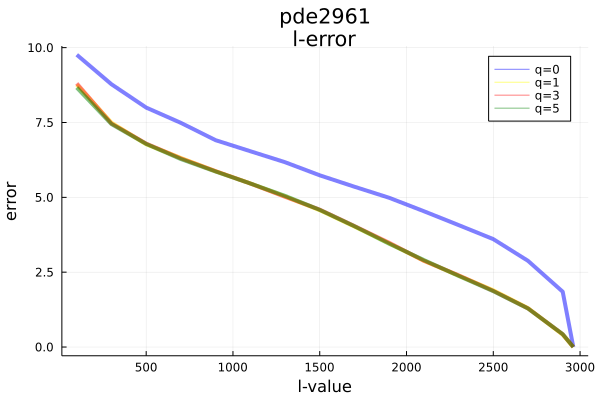

In [11]:
A = mmread("data/pde2961.mtx")
ra = 2961
xs = collect(100:200:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er0 = []
er1 = []
er3 = []
er5 = []
for i in xs 
    Q0 = rpi(A,i,0)
    append!(er0,opnorm((1.0I - Q0*Q0')*A))
end
plot(xs, er0, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="pde2961\nl-error", label="q=0")

for i in xs 
        Q1 = rpi(A,i,1)
        append!(er1,opnorm((1.0I - Q1*Q1')*A))
end
plot!(xs, er1, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :yellow), label="q=1")

for i in xs 
    Q3 = rpi(A,i,1)
    append!(er3,opnorm((1.0I - Q3*Q3')*A))
end
plot!(xs, er3, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :red),label="q=3")

for i in xs 
    Q5 = rpi(A,i,1)
    append!(er5,opnorm((1.0I - Q5*Q5')*A))
end
plot!(xs, er5, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :green), label="q=5")


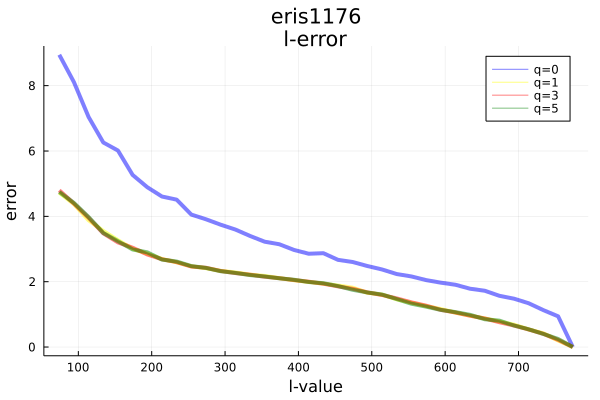

In [12]:
A = mmread("data/eris1176.mtx")
ra = 774
xs = collect(74:20:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er0 = []
er1 = []
er3 = []
er5 = []
for i in xs 
    Q0 = rpi(A,i,0)
    append!(er0,opnorm((1.0I - Q0*Q0')*A))
end
plot(xs, er0, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="eris1176\nl-error", label="q=0")

for i in xs 
        Q1 = rpi(A,i,1)
        append!(er1,opnorm((1.0I - Q1*Q1')*A))
end
plot!(xs, er1, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :yellow), label="q=1")

for i in xs 
    Q3 = rpi(A,i,1)
    append!(er3,opnorm((1.0I - Q3*Q3')*A))
end
plot!(xs, er3, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :red),label="q=3")

for i in xs 
    Q5 = rpi(A,i,1)
    append!(er5,opnorm((1.0I - Q5*Q5')*A))
end
plot!(xs, er5, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :green), label="q=5")


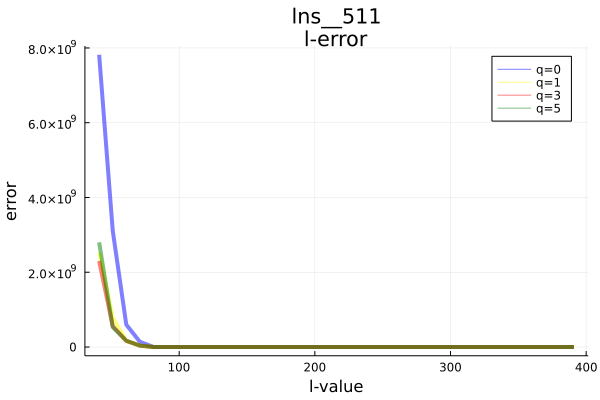

In [13]:
A = mmread("data/lns__511.mtx")
ra = 391
xs = collect(41:10:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er0 = []
er1 = []
er3 = []
er5 = []
for i in xs 
    Q0 = rpi(A,i,0)
    append!(er0,opnorm((1.0I - Q0*Q0')*A))
end
plot(xs, er0, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="lns__511\nl-error", label="q=0")

for i in xs 
        Q1 = rpi(A,i,1)
        append!(er1,opnorm((1.0I - Q1*Q1')*A))
end
plot!(xs, er1, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :yellow), label="q=1")

for i in xs 
    Q3 = rpi(A,i,1)
    append!(er3,opnorm((1.0I - Q3*Q3')*A))
end
plot!(xs, er3, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :red),label="q=3")

for i in xs 
    Q5 = rpi(A,i,1)
    append!(er5,opnorm((1.0I - Q5*Q5')*A))
end
plot!(xs, er5, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :green), label="q=5")


As expected with this algorithm the decay of error is faster than the basic one.

### Algorithm 4.5 Fast Randomized Range Finder

Input: mxn matrix $A$, integer $l$.

Output: mxl matrix $Q$, whose range approximates $A$.

1. Draw an $nxl$ SRFT random matrix $\Omega$
2. Form the $mxl$ matrix $Y=A \Omega $
3. Construct an $mxl$ matrix $Q$ whose columns form an orthonormal basis for the range of $Y$.

SRFT is subsampled random Fourier transform. It is a structured random matrix.

$ \Omega = \sqrt{\frac{n}{l}}DFR$
- D is an $n \times n$ diagonal matrix whose entries are independent random variables uniformly distributed on the complex unit circle.
- F is the $n \times n$ unitary discrete Fourier Transform (DFT), whose entries take the values $f_{pq} = n^{-1/2}e^{-2\pi (p-1)(q-1) / n}$ for $p,q = 1,2,3,...,n$
- Ris an $n \times l$ matrix that samples l coordinates from n uniformly at random; i.e., its $l$ columns are drawn randomly without replacement from the columns of the $ n \times n$ identity matrix.

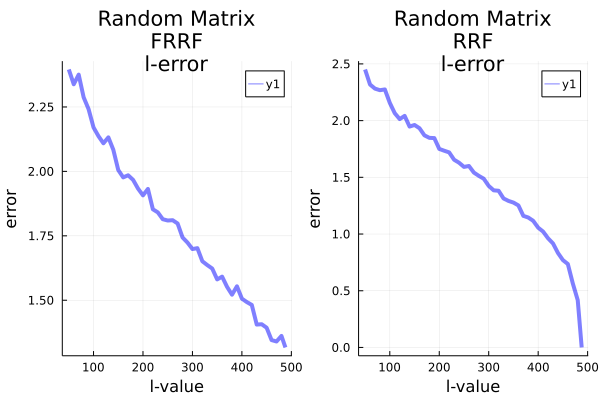

In [34]:
A = mmread("data/random_sparse.mtx")
ra = rank(A)
xs = collect(50:10:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = frrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end

p1 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="Random Matrix\nFRRF\nl-error")

er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p2 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="Random Matrix\nRRF\nl-error")

plot!(p1,p2)

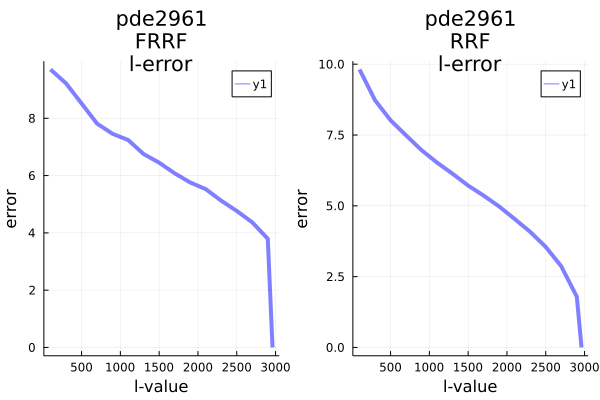

In [35]:
A = mmread("data/pde2961.mtx")
# @show rank(A) yields rank of A is 2961
ra = 2961
xs = collect(100:200:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = frrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p1 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="pde2961\nFRRF\nl-error")

er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p2 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="pde2961\nRRF\nl-error")

plot!(p1,p2)

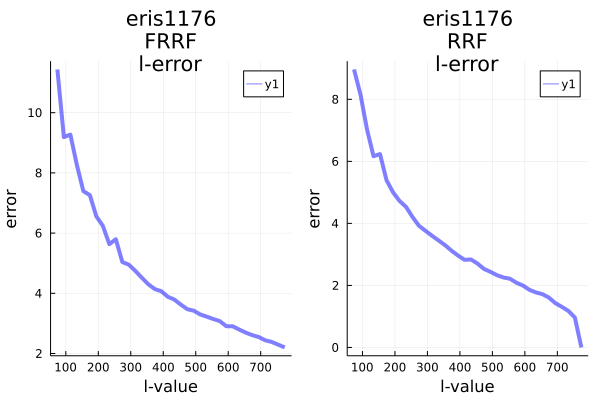

In [36]:
A = mmread("data/eris1176.mtx")
ra = 774
xs = collect(74:20:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = frrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p1 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="eris1176\nFRRF\nl-error")

er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p2 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="eris1176\nRRF\nl-error")

plot!(p1,p2)

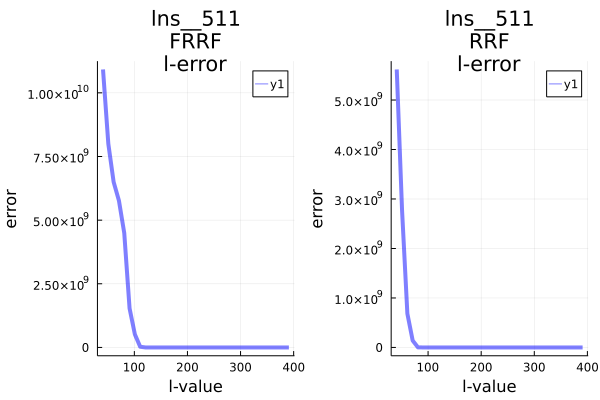

In [39]:
A = mmread("data/lns__511.mtx")
ra = 391
xs = collect(41:10:ra)
if xs[end] != ra
    xs = [xs ; ra]
end
er = zeros(size(xs))
index = 1
for i in xs 
    Q = frrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p1 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="lns__511\nFRRF\nl-error")

er = zeros(size(xs))
index = 1
for i in xs 
    Q = rrf(A,i)
    er[index] = opnorm((1.0I - Q*Q')*A)
    index += 1
end
p2 = plot(xs, er, xaxis=("l-value"), yaxis="error", line = (0.5, 4, :blue), title="lns__511\nRRF\nl-error")

plot!(p1,p2)

### Algorithm 5.1 SVD

Input: $m \times n$ matrix $A$, $m \times k$ matrix $Q$ with $\Vert A- QQ^*A \Vert \lt \epsilon$ for a desired $\epsilon$.

Output: Matrices $U,S,V$ where $U,V$ are orthonormal and $S$ non-negative diagonal matrices.

1. Form the matrix $B = Q^*A$
2. Compute an SVD ot the small matrix $B=\bar{U} \Sigma V^*$
3. Form the orhtonormal matrix $U = Q \bar{U}$


In [54]:
A = mmread("data/random_sparse.mtx")
Qh = mmread("data/4.2_random_sparse_output.mtx")
Q,S,V = direct_svd(A,Matrix(Qh));


In [ ]:
A = mmread("data/pde2961.mtx")
Qh = mmread("data/q_5.1.mtx")
Q,S,V = direct_svd(A,Matrix(Qh));

In [ ]:
A = mmread("data/eris1176.mtx")
Qh = mmread("data/4.2_eris1176_output.mtx")
Q,S,V = direct_svd(A,Matrix(Qh));

In [ ]:
A = mmread("data/lns__511.mtx")
Qh = mmread("data/4.2_lns__511_output.mtx")
Q,S,V = direct_svd(A,Matrix(Qh));

20 September Meeting Notes:
1. Compare julia with matlab on some selected algorithm runs in time.
2. Deadlines for summer practice submissions will be discussed with student affair.
3. Plots of algorithms 4.5 and 4.1 superposed. (and same for all relevant plots)
4. Time comparisons for relevant algorithms
5. At lines 108, 1011, 116, 133 is there a way to reduce the code to vector multiplication instead of matrix multp.
6. For SVD outputs the actual singular values and calculated ones will be compared in reports.